## Reconhecimento de qualidade e frutas
Foi disponibilizado umas pasta chamada qualidade que contém 2 subpastas com imgs de frutas de boa qualidade e não tão boa. Essa pasta foi usada para treinar o 'modelo_qualidade'.

Outra pasta disponibilzada foi a fruta_treinamento,com 10 subpastas cujo contem as imagens que foram usadas pra treinar o reconhecimento, cada img está em pasta com o nome da fruta a qual se refere.

In [1]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import os
import time
import json

ModuleNotFoundError: No module named 'google'

In [1]:
#Classe
classes_frutas=['alface','banana','cenoura','maca','morango','pera']
classes_qualidade=['bom','ruim']

##Função para tirar fundo da imagem


In [14]:
def remover_fundo(imagem):
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    fundo_branco = np.ones_like(imagem_cinza) * 255

    diferenca_fundo = cv2.absdiff(imagem_cinza, fundo_branco)

    _, threshold = cv2.threshold(diferenca_fundo, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contornos, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mascaras = []
    objetos = []

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area > 100:  # Ajuste o valor do limite de área conforme necessário
            mascara = np.zeros_like(imagem_cinza)
            cv2.drawContours(mascara, [contorno], -1, (255), thickness=cv2.FILLED)
            mascaras.append(mascara)
            objeto = cv2.bitwise_and(imagem, imagem, mask=mascara)
            objetos.append(objeto)

    # Criar uma imagem vazia para mesclar os objetos sem fundo
    resultado = np.zeros_like(imagem)

    # Mesclar os objetos sem fundo na imagem resultado
    for objeto in objetos:
        resultado = cv2.add(resultado, objeto)

    return resultado

##Modelo treinado para reconher fruta


In [15]:
# Insira a pasta com as frutas, de preferência que estejam separadas cada img de fruta em uma subpasta
pasta_frutas = '/content/fruits'

# Tamanho para redimensionar a imagem
target_size = (128,128)

imagens = []
rotulos = []
##Essa função percorre as pastas com as frutas. O nome das classes será dado de acordo com nome na
for classe in os.listdir(pasta_frutas):
    pasta_classe = os.path.join(pasta_frutas, classe)
    if os.path.isdir(pasta_classe):
        for imagem_nome in os.listdir(pasta_classe):
            caminho_imagem = os.path.join(pasta_classe, imagem_nome)
            imagem = cv2.imread(caminho_imagem)
            if imagem is None:
                print(f"Erro ao ler a imagem: {caminho_imagem}")
                continue
            imagem = cv2.resize(imagem, target_size)
            imagem_sem_fundo = remover_fundo(imagem)  
            imagens.append(imagem_sem_fundo)
            rotulos.append(classe)

X = np.array(imagens)
y = np.array(rotulos)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

X_treinamento = X_treinamento / 255.0
X_teste = X_teste / 255.0


modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(63, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])


modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

modelo.fit(X_treinamento, y_treinamento, epochs=30, batch_size=32)

predicoes = np.argmax(modelo.predict(X_teste), axis=-1)
acuracia = accuracy_score(y_teste, predicoes)
print('Acurácia:', acuracia)




Epoch 1/30
7/7 [==============================] - 10s 1s/step - loss: 1.9579 - accuracy: 0.2072
Epoch 2/30
7/7 [==============================] - 9s 1s/step - loss: 1.6851 - accuracy: 0.3514
Epoch 3/30
7/7 [==============================] - 8s 1s/step - loss: 1.5026 - accuracy: 0.4730
Epoch 4/30
7/7 [==============================] - 9s 1s/step - loss: 1.2455 - accuracy: 0.5631
Epoch 5/30
7/7 [==============================] - 9s 1s/step - loss: 1.2186 - accuracy: 0.6081
Epoch 6/30
7/7 [==============================] - 8s 1s/step - loss: 1.1510 - accuracy: 0.6441
Epoch 7/30
7/7 [==============================] - 8s 1s/step - loss: 0.8927 - accuracy: 0.7703
Epoch 8/30
7/7 [==============================] - 9s 1s/step - loss: 0.8615 - accuracy: 0.7342
Epoch 9/30
7/7 [==============================] - 9s 1s/step - loss: 0.7323 - accuracy: 0.7838
Epoch 10/30
7/7 [==============================] - 8s 1s/step - loss: 0.6845 - accuracy: 0.8423
Epoch 11/30
7/7 [==============================]

##Modelo para reconhcer qualidade

In [7]:

# Insira a pasta com as qualidades, de preferência que estejam separadas cada img de fruta em uma subpasta
pasta_frutas = '/content/fruits_quality'

# Tamanho para redimensionar a imagem
target_size = (128,128)

imagens = []
rotulos = []
##Essa função percorre as pastas com as frutas. O nome das classes será dado de acordo com nome na
for classe in os.listdir(pasta_frutas):
    pasta_classe = os.path.join(pasta_frutas, classe)
    if os.path.isdir(pasta_classe):
        for imagem_nome in os.listdir(pasta_classe):
            caminho_imagem = os.path.join(pasta_classe, imagem_nome)
            imagem = cv2.imread(caminho_imagem)
            if imagem is None:
                print(f"Erro ao ler a imagem: {caminho_imagem}")
                continue
            imagem = cv2.resize(imagem, target_size)
            imagem_sem_fundo = remover_fundo(imagem)  
            imagens.append(imagem_sem_fundo)
            rotulos.append(classe)

X = np.array(imagens)
y = np.array(rotulos)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

X_treinamento = X_treinamento / 255.0
X_teste = X_teste / 255.0



modelo_qualidade = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(62, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])


modelo_qualidade.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

modelo_qualidade.fit(X_treinamento, y_treinamento, epochs=30, batch_size=32)

predicoes = np.argmax(modelo_qualidade.predict(X_teste), axis=-1)
acuracia = accuracy_score(y_teste, predicoes)
print('Acurácia:', acuracia)




Epoch 1/30
4/4 [==============================] - 2s 318ms/step - loss: 1.0073 - accuracy: 0.5612
Epoch 2/30
4/4 [==============================] - 1s 316ms/step - loss: 0.8742 - accuracy: 0.6327
Epoch 3/30
4/4 [==============================] - 1s 313ms/step - loss: 0.7763 - accuracy: 0.5918
Epoch 4/30
4/4 [==============================] - 1s 311ms/step - loss: 0.7460 - accuracy: 0.7245
Epoch 5/30
4/4 [==============================] - 1s 335ms/step - loss: 0.6424 - accuracy: 0.8776
Epoch 6/30
4/4 [==============================] - 2s 453ms/step - loss: 0.5373 - accuracy: 0.8673
Epoch 7/30
4/4 [==============================] - 1s 308ms/step - loss: 0.4599 - accuracy: 0.9184
Epoch 8/30
4/4 [==============================] - 1s 310ms/step - loss: 0.4267 - accuracy: 0.9286
Epoch 9/30
4/4 [==============================] - 1s 311ms/step - loss: 0.4834 - accuracy: 0.8776
Epoch 10/30
4/4 [==============================] - 1s 309ms/step - loss: 0.3838 - accuracy: 0.9286
Epoch 11/30
4/4 [==

##Teste retirar fundo



Saving cenoura.jfif to cenoura (12).jfif


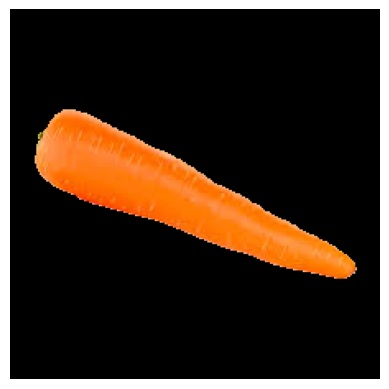

In [16]:

# Fazer upload da imagem
uploaded = files.upload()

# Carregar a imagem
imagem = cv2.imread(next(iter(uploaded)))

# Remover o fundo da imagem e obter a imagem resultante
imagem_sem_fundo = remover_fundo(imagem)

# Exibir a imagem resultante
imagem_sem_fundo_rgb = cv2.cvtColor(imagem_sem_fundo, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_sem_fundo_rgb)
plt.axis('off')
plt.show()


##Reconhecimento de mútiplas frutas em uma imagem para definir qualidade



Saving testeMacaBananaJuntas.jfif to testeMacaBananaJuntas (7).jfif
1/1 [==============================] - 0s 19ms/step


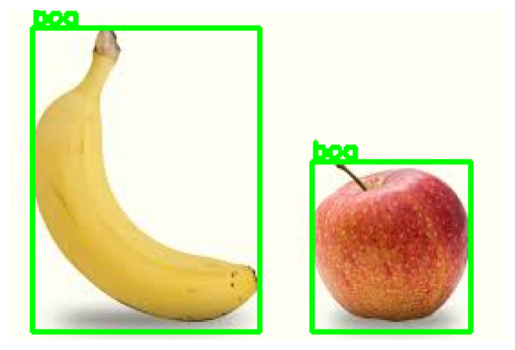

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
classes_qualidade=['boa','ruim']
def detectar_frutas(imagem_sem_fundo, modelo):
    
    imagem_gray = cv2.cvtColor(imagem_sem_fundo, cv2.COLOR_BGR2GRAY)

    _, imagem_bin = cv2.threshold(imagem_gray, 0, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(imagem_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        pedaco = imagem_sem_fundo[y:y+h, x:x+w]
        target_size = 128  
        imagem_redimensionada = cv2.resize(pedaco, (target_size, target_size))
        imagem_preprocessada = imagem_redimensionada / 255.0
        imagem_preprocessada = np.expand_dims(imagem_preprocessada, axis=0)

        predicao = modelo_qualidade.predict(imagem_preprocessada)
        classe_predita = np.argmax(predicao)
        nome_fruta = classes_qualidade[classe_predita]

        # Desenhar o retângulo e o texto na imagem com o fundo
        cv2.rectangle(imagem, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(imagem, nome_fruta, (x, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

 
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


uploaded = files.upload()
imagem = cv2.imdecode(np.frombuffer(next(iter(uploaded.values())), np.uint8), cv2.IMREAD_COLOR)
imagem_sem_fundo_qualidade = remover_fundo(imagem)

detectar_frutas(imagem_sem_fundo_qualidade, modelo_qualidade)



##Reconhecimento de qualidade de fruta  e identificação de fruta simultaneo em uma imagem isolada



Saving transferir (23).jfif to transferir (23) (3).jfif
1/1 [==============================] - 0s 20ms/step
[[0.25302964 0.74697036]]
1/1 [==============================] - 0s 26ms/step
[[0.05405354 0.03077058 0.15251122 0.03825685 0.03617034 0.6882375 ]]
{
    "nome": "pera",
    "classificacao": "ruim"
}


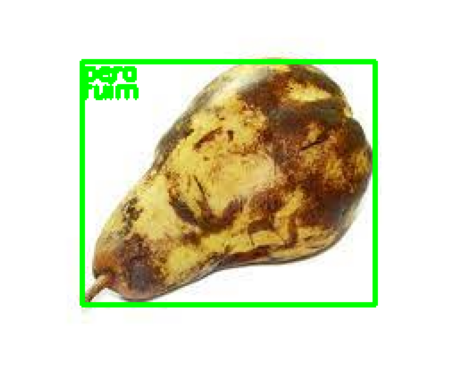

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detectar_frutas(imagem_sem_fundo, modelo_qualidade):
   
    imagem_gray = cv2.cvtColor(imagem_sem_fundo, cv2.COLOR_BGR2GRAY)
    _, imagem_bin = cv2.threshold(imagem_gray, 0, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(imagem_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        pedaco = imagem_sem_fundo[y:y+h, x:x+w]


        target_size = 128  
        imagem_redimensionada = cv2.resize(pedaco, (target_size, target_size))
        imagem_preprocessada = imagem_redimensionada / 255.0
        imagem_preprocessada = np.expand_dims(imagem_preprocessada, axis=0)

        predicao_qualidade = modelo_qualidade.predict(imagem_preprocessada)
        print(predicao_qualidade)
        classe_predita = np.argmax(predicao_qualidade)
        qualidade = classes_qualidade[classe_predita]
       
        predicao_fruta = modelo.predict(imagem_preprocessada)
        print(predicao_fruta)
        classe_predita_fruta = np.argmax(predicao_fruta)
        fruta= classes_frutas[classe_predita_fruta]
      
        cv2.rectangle(imagem, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(imagem, qualidade, (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        cv2.putText(imagem,fruta, (x, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        nome_fruta = fruta
        classificacao = qualidade

         # Criar o dicionário JSON
        data = {
            "nome": nome_fruta,
            "classificacao": classificacao
        }

    # Exibir o dicionário JSON
        json_data = json.dumps(data, indent=4)
        print(json_data)
    # Exibir a imagem com os retângulos
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# Fazer upload da imagem
uploaded = files.upload()

imagem = cv2.imdecode(np.frombuffer(next(iter(uploaded.values())), np.uint8), cv2.IMREAD_COLOR)
imagem_sem_fundo = remover_fundo(imagem)


# Chamar a função para detectar as frutas e fazer as predições
detectar_frutas(imagem_sem_fundo, modelo_qualidade)


##Reconhecimento por vídeo

In [ ]:

# Definir a quantidade de segundos entre os prints
intervalo_segundos = 5

# Abrir o vídeo
video_path = ''
cap = cv2.VideoCapture(video_path)

# Obter as informações de largura e altura do vídeo
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Definir o codec de saída e criar o objeto VideoWriter para salvar os frames
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (width, height))

# Variável para controlar o tempo entre os prints
tempo_anterior = time.time()

while cap.isOpened():
    # Ler o próximo frame do vídeo
    ret, frame = cap.read()
    if not ret:
        break

    # Obter o tempo atual
    tempo_atual = time.time()

    # Verificar se passou o intervalo de tempo definido
    if tempo_atual - tempo_anterior >= intervalo_segundos:
        # Redimensionar a imagem para o tamanho desejado
        target_size = 128
        imagem_redimensionada = cv2.resize(frame, (target_size, target_size))
        imagem=remover_fundo(imagem_redimensionada)
        imagem_preprocessada = imagem / 255.0
        imagem_preprocessada = np.expand_dims(imagem_preprocessada, axis=0)

        # Realizar a predição da fruta na imagem tratada
        predicao = modelo.predict(imagem_preprocessada)
        classe_predita = np.argmax(predicao)
        nome_fruta = classes_frutas[classe_predita]

        # Desenhar o retângulo e o texto na imagem
        x, y, w, h = 10, 10, 100, 100  # Exemplo de coordenadas e tamanho do retângulo
        cv2.rectangle(imagem, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(imagem, nome_fruta, (x, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

        # Exibir a imagem com a fruta prevista
        plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Salvar o frame no arquivo de vídeo de saída
        out.write(imagem)

        # Atualizar o tempo anterior
        tempo_anterior = tempo_atual

    # Aguardar 1 segundo antes de exibir o próximo quadro
    time.sleep(1)

    # Verificar se a tecla 'q' foi pressionada para encerrar o loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar os recursos
cap.release()
out.release()
cv2.destroyAllWindows()
